# Telugu POS with PyTorch

In [1]:
!pip install datasets
!pip install tokenizers 
!pip install conllu 
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-pyth

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

from datasets import load_dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

seed with the meaning of life

In [3]:
SEED = 42

import random
from numpy import random as nprnd

random.seed(SEED)
nprnd.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

let's take a look at the data

In [4]:
pd.set_option('display.max_colwidth', None)
dataset = load_dataset(
   'universal_dependencies', 'te_mtg')
dataset.set_format(type="pandas", columns=["text", "tokens", "upos"])
dataset['validation'][:10]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1051 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/131 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/te_mtg/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,text,tokens,upos
0,మనం ఎందుకు అన్నం తింటాం ?,"[మనం, ఎందుకు, అన్నం, తింటాం, ?]","[11, 14, 0, 16, 1]"
1,నువ్వు పని చెయ్యాలి .,"[నువ్వు, పని, చెయ్యాలి, .]","[11, 0, 16, 1]"
2,నేను ఆ పని చెయ్యాల్సి వచ్చింది .,"[నేను, ఆ, పని, చెయ్యాల్సి, వచ్చింది, .]","[11, 8, 0, 16, 16, 1]"
3,మీ తల్లిదండ్రుల ఊరు ఏమిటి ?,"[మీ, తల్లిదండ్రుల, ఊరు, ఏమిటి, ?]","[11, 0, 0, 11, 1]"
4,అవి మా ఇళ్ళ గోడలు .,"[అవి, మా, ఇళ్ళ, గోడలు, .]","[11, 11, 0, 0, 1]"
5,ఇది పళ్ళ బుట్ట .,"[ఇది, పళ్ళ, బుట్ట, .]","[11, 0, 0, 1]"
6,ఇవ్వేళ ఆమె ఇక్కడ లేదు .,"[ఇవ్వేళ, ఆమె, ఇక్కడ, లేదు, .]","[0, 11, 14, 16, 1]"
7,నిన్న మేము ఊళ్ళో లేము .,"[నిన్న, మేము, ఊళ్ళో, లేము, .]","[14, 11, 0, 16, 1]"
8,దుకాణాల్లో బియ్యం లేవు .,"[దుకాణాల్లో, బియ్యం, లేవు, .]","[0, 0, 16, 1]"
9,అతను నన్ను వెళ్ళమన్నాడు .,"[అతను, నన్ను, వెళ్ళమన్నాడు, .]","[11, 11, 16, 1]"


examine the upos column 

In [5]:
val_tags = dataset['validation'].features['upos'].feature.names
[f'{i:2}: {p}' for (i,p) in enumerate(val_tags)]

[' 0: NOUN',
 ' 1: PUNCT',
 ' 2: ADP',
 ' 3: NUM',
 ' 4: SYM',
 ' 5: SCONJ',
 ' 6: ADJ',
 ' 7: PART',
 ' 8: DET',
 ' 9: CCONJ',
 '10: PROPN',
 '11: PRON',
 '12: X',
 '13: _',
 '14: ADV',
 '15: INTJ',
 '16: VERB',
 '17: AUX']

we can observe the main POS tags are Verb, Pronoun and Adjective and that each sentnce ends in a punctuation tag.

let's make sure that the order of tags are the same for train, test and validation

In [6]:
train_tags = dataset['train'].features['upos'].feature.names
dev_tags = dataset['validation'].features['upos'].feature.names
test_tags = dataset['test'].features['upos'].feature.names
assert len(train_tags) == len(dev_tags) == len(test_tags), print("the tags indices does not match")
for train_tag, dev_tag, test_tag in zip(train_tags, dev_tags, test_tags):
  assert train_tag == dev_tag == test_tag, print("the tags indices does not match")




# Tokenizer

Our documents are already tokenized, so we'll just use a white space split on the existing tokens to train the tokenizer



In [7]:
PAD_ID = 0

def map_instance_to_whitespace_tokenizable_text(inst) -> str:
    return " ".join(inst['tokens'])

def make_tokenizers():
    dataset = load_dataset("universal_dependencies", "te_mtg", split="train")
    tokenizer = Tokenizer(WordLevel(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = WhitespaceSplit()
    trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"])
    tokenizer.train_from_iterator([map_instance_to_whitespace_tokenizable_text(i) for i in dataset],
                                  trainer=trainer,
                                  length=len(dataset))
    tokenizer.enable_padding(pad_id=PAD_ID, pad_token="<PAD>")

    tag_tokenizer = Tokenizer(WordLevel(vocab={str(i): i for i in range(len(val_tags)+1)}))
    tag_tokenizer.enable_padding(pad_id=len(val_tags), pad_token=str(len(val_tags)))
    return tokenizer, tag_tokenizer

In [8]:
tokenizer, tag_tokenizer = make_tokenizers()

tokenizer.save("ud-te-tokenizer.json", pretty=True)
tag_tokenizer.save("ud-te-tag-tokenizer.json", pretty=True)

print(tokenizer.get_vocab_size())
print(tag_tokenizer.get_vocab_size())

1745
19


## Modeling

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

we'll use an lstm. we'll pass the last layer through a linear layer and use the output as predictions.
![](https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png)<br>

In [10]:
class PosTagger(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                              embedding_dim,
                              padding_idx=tokenizer.padding["pad_id"])
        self.lstm = nn.LSTM(input_size=embedding_dim,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    batch_first=True,)
        self.fc = nn.Linear(hidden_size, tag_tokenizer.get_vocab_size())


    def forward(self, x) -> torch.Tensor:
        embs = self.embedding(x)
        output, (hidden, cell) = self.lstm(embs)
        return self.fc(output)

# Training 

In [11]:
pad_tag = len(val_tags)
def train(model: PosTagger,
          optimizer: optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss,
          dataloader: DataLoader) -> dict:
    model.train()
    total = 0
    correct = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        sentences = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        probs = model(sentences)        
        loss = loss_fn(probs.permute(0,2,1), labels)
        loss.backward()
        optimizer.step()

        preds = probs.argmax(dim=2)
        for i in range(len(preds)):
          for j in range(len(preds[0])):
            if labels[i][j] == pad_tag:
              continue
            total += 1
            correct += (labels[i][j]==preds[i][j]).int()

        ###
    return correct / total


def evaluate(model: PosTagger,
             dataloader: torch.utils.data.DataLoader) -> dict:
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            sentences = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            probs = model(sentences)
            preds = probs.argmax(dim=2)
        
            for i in range(len(preds)):
              for j in range(len(preds[0])):
                if labels[i][j] == pad_tag:
                  continue
                total += 1
                correct += (labels[i][j]==preds[i][j]).int()

    return correct / total

hyper parameters

In [12]:
BATCH_SIZE = 24
EMB_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
EPOCHS = 5

In [13]:
def deep_stringify(x):
    if type(x) == int:
        return str(x)
    return [deep_stringify(a) for a in x]

dataset = load_dataset("universal_dependencies", "te_mtg")
dataset = dataset.map(lambda ins: {
    "input_ids": [e.ids for e in tokenizer.encode_batch(ins['tokens'],
                                                        is_pretokenized=True)],
    "labels": [e.ids for e in tag_tokenizer.encode_batch(deep_stringify(ins['upos']),
                                                        is_pretokenized=True)],
}, batched=True, batch_size=BATCH_SIZE)
dataset.set_format(type="torch", columns=["input_ids", "labels"])

train_dataloader = DataLoader(dataset["train"], batch_size=BATCH_SIZE)
val_dataloader = DataLoader(dataset["validation"], batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset["test"], batch_size=BATCH_SIZE)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

first try

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:
Training Accuracy: 27.47%
Validation Accuracy: 45.92%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2:
Training Accuracy: 55.31%
Validation Accuracy: 60.88%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3:
Training Accuracy: 61.14%
Validation Accuracy: 62.99%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4:
Training Accuracy: 66.12%
Validation Accuracy: 66.01%


Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5:
Training Accuracy: 71.41%
Validation Accuracy: 70.85%


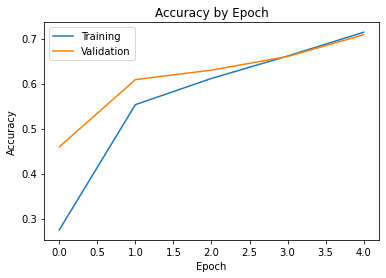

In [14]:
model = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=len(val_tags)).to(device)
optimizer = optim.Adam(model.parameters())

### for exercise 5

loss_fn = nn.CrossEntropyLoss(ignore_index=18)

###

train_accuracies = []
validation_accuracies = []
for epoch in range(EPOCHS):
    train_acc = train(model, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model, val_dataloader)
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {100 * train_acc:.2f}%")
    print(f"Validation Accuracy: {100 * val_acc:.2f}%")
    train_accuracies.append(train_acc.cpu().numpy())
    validation_accuracies.append(val_acc.cpu().numpy())

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

we can notice that accuarcy(on both train and validation) grows as a function of the number of epochs.
let's try increasing the number of epochs and the dimension of the embeddings

epochs:

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

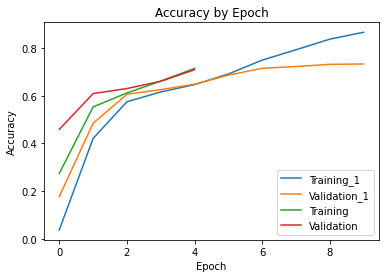

In [15]:
EPOCHS_1 = 10

model_1 = PosTagger(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=len(val_tags)).to(device)
optimizer = optim.Adam(model_1.parameters())

loss_fn = nn.CrossEntropyLoss()
train_accuracies_1 = []
validation_accuracies_1 = []
for epoch in range(EPOCHS_1):
    train_acc = train(model_1, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model_1, val_dataloader)
    train_accuracies_1.append(train_acc.cpu().numpy())
    validation_accuracies_1.append(val_acc.cpu().numpy())

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="Training_1")
plt.plot(validation_accuracies_1, label="Validation_1")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

embeddings dim

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

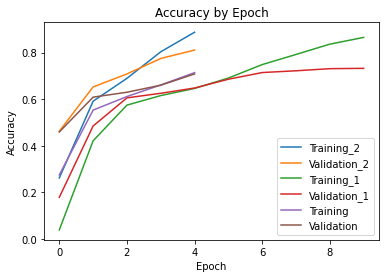

In [16]:
EMB_DIM_1 = 768

model_2 = PosTagger(embedding_dim=EMB_DIM_1,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=len(val_tags)).to(device)
optimizer = optim.Adam(model_2.parameters())

loss_fn = nn.CrossEntropyLoss()
train_accuracies_2 = []
validation_accuracies_2 = []
for epoch in range(EPOCHS):
    train_acc = train(model_2, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model_2, val_dataloader)
    train_accuracies_2.append(train_acc.cpu().numpy())
    validation_accuracies_2.append(val_acc.cpu().numpy())

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_2, label="Training_2")
plt.plot(validation_accuracies_2, label="Validation_2")
plt.plot(train_accuracies_1, label="Training_1")
plt.plot(validation_accuracies_1, label="Validation_1")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

let's train with 10 epochs, a dim of 768 for the embeddings, an hidden-dim of 256, a batch size of 8 and a bidirectional LSTM with a different optimizer

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

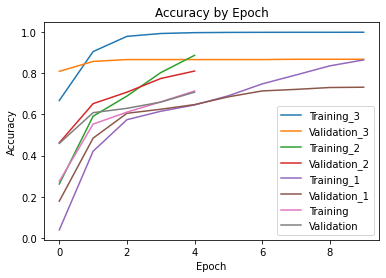

In [34]:
class PosTagger_1(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 hidden_size: int,
                 num_tags: int,
                 num_layers: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(),
                              embedding_dim,
                              padding_idx=tokenizer.padding["pad_id"])
        self.lstm = nn.LSTM(input_size=embedding_dim,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    batch_first=True, 
                    bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, tag_tokenizer.get_vocab_size())


    def forward(self, x) -> torch.Tensor:
        embs = self.embedding(x)
        output, (hidden, cell) = self.lstm(embs)
        return self.fc(output)

BATCH_SIZE = 8
EMB_DIM = 768
HIDDEN_DIM = 256
NUM_LAYERS = 2
EPOCHS = 10

model_3 = PosTagger_1(embedding_dim=EMB_DIM,
                  hidden_size=HIDDEN_DIM,
                  num_layers=NUM_LAYERS,
                  num_tags=len(val_tags)).to(device)
optimizer = optim.Adagrad(model_3.parameters())

loss_fn = nn.CrossEntropyLoss()
train_accuracies_3 = []
validation_accuracies_3 = []
for epoch in range(EPOCHS):
    train_acc = train(model_3, optimizer, loss_fn,
                          train_dataloader)
    val_acc = evaluate(model_3, val_dataloader)
    train_accuracies_3.append(train_acc.cpu().numpy())
    validation_accuracies_3.append(val_acc.cpu().numpy())

plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_3, label="Training_3")
plt.plot(validation_accuracies_3, label="Validation_3")
plt.plot(train_accuracies_2, label="Training_2")
plt.plot(validation_accuracies_2, label="Validation_2")
plt.plot(train_accuracies_1, label="Training_1")
plt.plot(validation_accuracies_1, label="Validation_1")
plt.plot(train_accuracies, label="Training")
plt.plot(validation_accuracies, label="Validation")
plt.legend();

## testing

In [35]:
print(evaluate(model_3, test_dataloader).item())

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

0.8626907467842102


0.86 acc, not so bad